# **Kaggle Survey Report** 
<br>
Author: Stephanie Anagnostou 
<br>
University of Toronto, Faculty of Engineering
<br>
February 28, 2020

## **Table of Contents**



### [Introduction](#Introduction)
<br>

[Table 1.1: Description of Variables in the Kaggle Data Set](#Table-1.1:-Description-of-Variables-in-the-Kaggle-Data-Set)
<br>

### [Methodology](#Methodology)

<br>

[Data Cleaning](#Data-Cleaning)
<br>

[Feature Selection](#Feature-Selection)
<br>

### [Results](#Results)
<br>

[Exploratory Data Analysis](#Exploratory-Data-Analysis)
<br>

[Model Implementation](#Model-Implementation)
<br>

[Least Absolute Shrinkage and Selection Operator (LASSO)](#Least-Absolute-Shrinkage-and-Selection-Operator-(LASSO))
<br>

[Logistic Regression](#Logistic-Regression)
<br>

[Probability Distribution](#Probability-Distribution )
<br>

### [Discussion](#Discussion)
<br>

[Model Tuning](#Model-Tuning)
<br>

[Testing](#Testing)
<br>

[Learning Curve](#Learning-Curve)
<br>

### [References](#References)

# Introduction

Data Science is a rapidly growing field as businesses today are faced with the common challenge of extracting data from their information systems to develop richer insights and fuel smart business decisions. According to Van der Aalst W. (2016), the majority of data is stored in large quantities (i.e. big data) which is in the unstructured form. Furthermore, businesses which can successfully align their data and information systems to their business processes will remain competitively positioned in the growing digital economy. McKinsey predicts there will be a talent shortage in the future for data scientists and organizations must quickly adapt to ensure human capital a priority to attract and retain the best (Hancock & Schaninger, 2019). This report aims to analyze a variety of features about data scientists and develop a model to predict the probability a respondent would fall into a particular salary bracket given a set of features. The results extracted from this report would be useful both for the data scientists and for the companies looking to attract and retain data science skill sets. 

The data for this report came from Kaggle's third annual Machine Learning and Data Science Survey. In total the survey consists of 19,717 responses from 171 countries and territories. For more information about the survey and on the sampling and data collection please [click this link](#https://www.kaggle.com/c/kaggle-survey-2019).

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np
%matplotlib inline
import sys 
import copy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import accuracy_score
import math
from mpl_toolkits import mplot3d

In [3]:
pd.set_option('display.max_columns',None)

##### **Table 1.1: Description of Variables in the Kaggle Data Set**

In [4]:
orig_pd_colwidth = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 150

In [5]:
url_schema = "http://analytics.romanko.ca/data/kaggle/survey_schema.csv"
df_schema = pd.read_csv(url_schema,skiprows=[i for i in range(2,11)]).T
print ("{:<10} {:<10}".format('Variable', 'Description'))
print(df_schema[1:])

Variable   Description
                                                                                                                                                0
Q1                                                                                                                    What is your age (# years)?
Q10                                                                                  What is your current yearly compensation (approximate $USD)?
Q11             Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?
Q12                        Who/what are your favorite media sources that report on data science topics? (Select all that apply) - Selected Choice
Q13                                On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice
Q14                            What is the primary tool that you use at work or school to analyze dat

In [6]:
import warnings
warnings.filterwarnings("ignore")

# **Methodology**

Created the dataframe and copied it with all the survey data.

In [7]:
kaggle = pd.read_csv("Kaggle_Salary.csv",skiprows=[1])
kaggle_new = kaggle.copy()

## **Data Cleaning**



### Deleting Columns

Delete columns which have more than 50% missing values.

Justify Approach
<br>
In total, 192 columns were deleted which had more than 50% missing values. The deleted columns were multiple parts of a single question which would have been deleted later on since they would have been highly correlated with each other. Consequently, these columns were empty because these multi-part questions asked respondents to "Select all that apply" which means the data is Missing At Random (MAR). It is possible, the meant unpopular choices were largely left unselected by the data scientists and therefore, this data is not useful in my analysis and actually will be detrimental for the regression accuracy. 

In [8]:
percent_null = kaggle_new.isnull().sum() / len(kaggle_new)
missing_feat = percent_null[percent_null>0.5].index
kaggle_new.drop(missing_feat, axis=1, inplace = True)

### Categorical Data Transformation to Numeric

**Technique 1 - Mapping**

Mapping categorical values which have a numerical order. 

Justify Approach
<br> 
In order to maintain the order integrity of this data I use Quantile Binning. This is because these values have a numeric order and they have a mean so instead of using binary transformation, which would not capture the order of the datasets I use mapping in python. Moreover, I chose to use the mean since the data ranges were not evenly spaced out and therefore, I felt the mean was able to better capture the data ranges in contrast with the median or mode. 

In [9]:
kaggle_new['Q10'] = kaggle_new['Q10'].map({'$0-999': 500, '1,000-1,999': 1500, '2,000-2,999': 2500, '3,000-3,999': 3500, '4,000-4,999': 4500, '5,000-7,499': 6250, '7,500-9,999': 8750, '10,000-14,999': 12500, '15,000-19,999': 17500, '20,000-24,999': 22500, '25,000-29,999': 27500, '30,000-39,999': 35000, '40,000-49,999': 45000, '50,000-59,999': 55000, '60,000-69,999': 65000,  '70,000-79,999': 75000, '80,000-89,999': 85000, '90,000-99,999': 95000, '100,000-124,999': 112500, '125,000-149,999': 137500, '150,000-199,999': 175000, '200,000-249,999': 225000, '250,000-299,999': 275000, '300,000-500,000': 400000, '> $500,000': 500000})
kaggle_new['Q1'] = kaggle_new['Q1'].map({'40-44': 42, '22-24': 23, '50-54': 52, '55-59': 57, '30-34': 32, '18-21': 20, '35-39': 37, '25-29': 27, '45-49': 47, '60-69': 65, '70+': 70})
kaggle_new['Q6'] = kaggle_new['Q6'].map({'> 10,000 employees': 10000, '1000-9,999 employees': 5500, '250-999 employees': 625, '50-249 employees': 150, '0-49 employees': 25})
kaggle_new['Q7'] = kaggle_new['Q7'].map({'20+': 20, '0': 0, '3-4': 3.5, '1-2': 1.5, '5-9': 7,'10-14':12,'15-19':17})
kaggle_new['Q2'] = kaggle_new['Q2'].map({'Male': 0, 'Female': 1})
kaggle_new['Q11'] = kaggle_new['Q11'].map({'> $100,000 ($USD)': 100000, '$10,000-$99,999': 55000, '$0 (USD)': 0, '$100-$999': 550, '$1000-$9,999': 5500, '$1-$99': 50})
kaggle_new['Q22'] = kaggle_new['Q22'].map({'Once': 1, 'Never': 0, '6-24 times': 15, '2-5 times': 3.5, '> 25 times': 25})
kaggle_new['Q23'] = kaggle_new['Q23'].map({'< 1 years': 0.5, '1-2 years': 1.5, '2-3 years': 2.5,  '3-4 years': 3.5, '4-5 years': 4.5, '5-10 years': 7.5, '10-15 years':12.5, '20+ years': 20})
kaggle_new['Q15'] = kaggle_new['Q15'].map({'I have never written code': 0, '< 1 years': 0.5, '1-2 years': 1.5, '3-5 years': 4,  '5-10 years': 7.5, '10-20 years': 15, '20+ years': 20})

### Replacing NaN with String Value

So for the columns which have missing values within the range of 20-50% I will remove the null values and replace with the string "Null." First, I will find which columns have null values. Since I already dropped all columns which have more then 50% missing, I can just create a mask for greater than 20% missing values and use that as the resultant segment. 

Justify Approach
<br>
These columns are Missing Not At Random (MNAR) and consequently, would be dangerous to delete. Therefore, in order to handle these values I will replace the NaN with a string called "Null" which will allow me to perform the regression analysis without having to delete the values. 

In [10]:
percent_null_1 = kaggle_new.isnull().sum() / len(kaggle_new)
missing_feat_20_to_50 = percent_null_1[percent_null_1>0.2].index
kaggle_new[missing_feat_20_to_50].head()

,Q12_Part_4,Q12_Part_8,Q13_Part_2,Q16_Part_1,Q18_Part_1,Q20_Part_2,Q21_Part_1,Q24_Part_1,Q24_Part_2,Q28_Part_1
0,"Kaggle (forums, blog, social media, etc)","Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)",Coursera,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)",Coursera,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",Python,Matplotlib,CPUs,Linear or Logistic Regression,NaN,Scikit-learn
2,NaN,"Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)",NaN,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",Python,Matplotlib,CPUs,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn
3,NaN,"Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)",NaN,NaN,Python,NaN,CPUs,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn
4,"Kaggle (forums, blog, social media, etc)",NaN,Coursera,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",Python,Matplotlib,CPUs,Linear or Logistic Regression,NaN,Scikit-learn


In [11]:
for col in missing_feat_20_to_50: 
    kaggle_new[col].replace(np.NaN, "Null", inplace = True)

In [12]:
kaggle_new[missing_feat_20_to_50].head()

,Q12_Part_4,Q12_Part_8,Q13_Part_2,Q16_Part_1,Q18_Part_1,Q20_Part_2,Q21_Part_1,Q24_Part_1,Q24_Part_2,Q28_Part_1
0,"Kaggle (forums, blog, social media, etc)","Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)",Coursera,Null,Null,Null,Null,Null,Null,Null
1,Null,"Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)",Coursera,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",Python,Matplotlib,CPUs,Linear or Logistic Regression,Null,Scikit-learn
2,Null,"Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)",Null,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",Python,Matplotlib,CPUs,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn
3,Null,"Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)",Null,Null,Python,Null,CPUs,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn
4,"Kaggle (forums, blog, social media, etc)",Null,Coursera,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",Python,Matplotlib,CPUs,Linear or Logistic Regression,Null,Scikit-learn


### Replacing NaN with the Mode

Now, for columns which have missing values between 1-20% I will insert the mode for these values. 

Justify Approach
<br>
Since the amount of missing values in this data set is low (between 1-20%) I feel it is safe to replace these NaN values with the mode of the column. I chose the mode because it works for both numeric and categorical data which simplifies and speeds up the data cleaning process.  

In [13]:
percent_null_1 = kaggle_new.isnull().sum() / len(kaggle_new)
missing_feat_1_to_20 = percent_null_1[percent_null_1>0.01].index
kaggle_new[missing_feat_1_to_20].head()

,Q2,Q11,Q14,Q15,Q19,Q22,Q23
0,0.0,100000.0,"Cloud-based data software & APIs (AWS, GCP, Azure, etc.)",0.0,NaN,NaN,NaN
1,0.0,55000.0,"Local development environments (RStudio, JupyterLab, etc.)",1.5,Python,1.0,2.5
2,0.0,0.0,"Local development environments (RStudio, JupyterLab, etc.)",0.5,Python,0.0,0.5
3,0.0,55000.0,"Advanced statistical software (SPSS, SAS, etc.)",20.0,Java,0.0,12.5
4,0.0,550.0,"Local development environments (RStudio, JupyterLab, etc.)",4.0,Python,15.0,2.5


In [14]:
for col in missing_feat_1_to_20: 
    kaggle_new[col].replace(np.NaN,  kaggle_new[col].mode(), inplace = True)

In [15]:
kaggle_new[missing_feat_1_to_20].head()

,Q2,Q11,Q14,Q15,Q19,Q22,Q23
0,0.0,100000.0,"Cloud-based data software & APIs (AWS, GCP, Azure, etc.)",0.0,Python,0.0,0.5
1,0.0,55000.0,"Local development environments (RStudio, JupyterLab, etc.)",1.5,Python,1.0,2.5
2,0.0,0.0,"Local development environments (RStudio, JupyterLab, etc.)",0.5,Python,0.0,0.5
3,0.0,55000.0,"Advanced statistical software (SPSS, SAS, etc.)",20.0,Java,0.0,12.5
4,0.0,550.0,"Local development environments (RStudio, JupyterLab, etc.)",4.0,Python,15.0,2.5


### List-Wise Deletion

For the columns which have less than 1% missing values I will drop those rows (i.e. conduct a list-wise deletion). In total there were 2107 rows with null values left in the data set which were dropped via list-wise deletion. 

Justify Approach
<br>
Since the amount of missing data is small and this missing data is not different from the complete data cases, I assume this data is Missing Completely At Random (MCAR). Consequently, it is safe to conduct a List-Wise Deletion for data which is MCAR without introducing bias into the sample.  

In [16]:
test = kaggle_new[kaggle_new.isna().any(axis=1)]
len(test) 

2107

In [17]:
kaggle_new.dropna(inplace = True)

### Removing Highly Correlated Values

I will drop columns which are representing the same data as my predicted value Q10. 

Justify Approach
<br>
Q10 is highly correlated with Q10_buckets, which is at 0.67, and Q10_Encoded is the encoded version of Q10. Therefore, I will drop the column "Q10_buckets" and "Q10_Encoded" since the values are already represented by the column "Q10" and this high correlation will create bias in the regression later on. 

In [18]:
kaggle_new_test = kaggle_new.copy()
kaggle_new_test['Q10']=kaggle_new_test['Q10'].astype('category').cat.codes
kaggle_new_test['Q10_buckets']=kaggle_new_test['Q10_buckets'].astype('category').cat.codes
print(kaggle_new_test['Q10'].corr(kaggle_new_test['Q10_buckets']))

0.6688118117251545


In [19]:
kaggle_new.drop(['Q10_buckets','Q10_Encoded'], axis=1, inplace = True)

### Categorical Data Transformation to Numeric

**Technique 2: Binary Transformation**

Transforming the data into binary values of 0 and 1. 

Justify Approach
<br>
In contrast to the data above, this data has no order and is categorical, not numeric. Therefore, in order to transform the data into numeric form I will use binary transformation which works well for unordered, categorical data. 

In [20]:
kaggle_new2 = pd.get_dummies(kaggle_new)

### Normalizing the dataset

Justify Approach
<br>
The values which had numeric order still need to be normalized to values between 0 and 1 in order to run the logistic regression. Consequently, my next step is to normalize these column values. To do this, I will iterate through all rows and divide each value by the max of the column.  

In [21]:
for col in kaggle_new2.columns:
    if col != "Q10":
        kaggle_new2[col]=kaggle_new2[col]/(abs(kaggle_new2[col])).max()

In [22]:
kaggle_new2.reset_index(inplace=True)
kaggle_new2.drop(['index'], axis=1, inplace = True)
kaggle_new2

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q5_OTHER_TEXT,Q6,Q7,Q9_OTHER_TEXT,Q10,Q11,Q12_OTHER_TEXT,Q13_OTHER_TEXT,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_OTHER_TEXT,Q17_OTHER_TEXT,Q18_OTHER_TEXT,Q19_OTHER_TEXT,Q20_OTHER_TEXT,Q21_OTHER_TEXT,Q22,Q23,Q24_OTHER_TEXT,Q25_OTHER_TEXT,Q26_OTHER_TEXT,Q27_OTHER_TEXT,Q28_OTHER_TEXT,Q29_OTHER_TEXT,Q30_OTHER_TEXT,Q31_OTHER_TEXT,Q32_OTHER_TEXT,Q33_OTHER_TEXT,Q34_OTHER_TEXT,Q3_Algeria,Q3_Argentina,Q3_Australia,Q3_Austria,Q3_Bangladesh,Q3_Belarus,Q3_Belgium,Q3_Brazil,Q3_Canada,Q3_Chile,Q3_China,Q3_Colombia,Q3_Czech Republic,Q3_Denmark,Q3_Egypt,Q3_France,Q3_Germany,Q3_Greece,Q3_Hong Kong (S.A.R.),Q3_Hungary,Q3_India,Q3_Indonesia,"Q3_Iran, Islamic Republic of...",Q3_Ireland,Q3_Israel,Q3_Italy,Q3_Japan,Q3_Kenya,Q3_Malaysia,Q3_Mexico,Q3_Morocco,Q3_Netherlands,Q3_New Zealand,Q3_Nigeria,Q3_Norway,Q3_Other,Q3_Pakistan,Q3_Peru,Q3_Philippines,Q3_Poland,Q3_Portugal,Q3_Republic of Korea,Q3_Romania,Q3_Russia,Q3_Saudi Arabia,Q3_Singapore,Q3_South Africa,Q3_South Korea,Q3_Spain,Q3_Sweden,Q3_Switzerland,Q3_Taiwan,Q3_Thailand,Q3_Tunisia,Q3_Turkey,Q3_Ukraine,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q3_Viet Nam,Q4_Bachelor’s degree,Q4_Doctoral degree,Q4_I prefer not to answer,Q4_Master’s degree,Q4_No formal education past high school,Q4_Professional degree,Q4_Some college/university study without earning a bachelor’s degree,Q5_Business Analyst,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician,Q8_I do not know,Q8_No (we do not use ML methods),Q8_We are exploring ML methods (and may one day put a model into production),"Q8_We have well established ML methods (i.e., models in production for more than 2 years)","Q8_We recently started using ML methods (i.e., models in production for less than 2 years)",Q8_We use ML methods for generating insights (but do not put working models into production),"Q12_Part_4_Kaggle (forums, blog, social media, etc)",Q12_Part_4_Null,"Q12_Part_8_Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)",Q12_Part_8_Null,Q13_Part_2_Coursera,Q13_Part_2_Null,"Q14_Advanced statistical software (SPSS, SAS, etc.)","Q14_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q14_Local development environments (RStudio, JupyterLab, etc.)",Q14_Other,"Q16_Part_1_Jupyter (JupyterLab, Jupyter Notebooks, etc)",Q16_Part_1_Null,Q18_Part_1_Null,Q18_Part_1_Python,Q19_Bash,Q19_C,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript,Q20_Part_2_ Matplotlib,Q20_Part_2_Null,Q21_Part_1_CPUs,Q21_Part_1_Null,Q24_Part_1_Linear or Logistic Regression,Q24_Part_1_Null,Q24_Part_2_Decision Trees or Random Forests,Q24_Part_2_Null,Q28_Part_1_ Scikit-learn,Q28_Part_1_Null
0,0.000501,0.600000,0.0,-1.0,-0.001156,1.0000,1.000,-0.007407,6250,1.0000,-0.002037,-0.001232,-0.001082,-0.002732,-0.002967,-0.000352,0.00000,-0.001311,0.000,-0.002809,-0.004808,-0.003279,-0.013514,-0.003774,-0.018868,0.00,0.025,-0.003861,-0.00885,-0.028571,-0.032258,-0.006173,-0.00885,-0.006993,-0.007042,-0.009259,-0.013514,-0.006944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.000463,0.600000,0.0,-1.0,0.000000,1.0000,1.000,-0.007407,275000,0.5500,-0.002037,-0.001232,-0.001082,

# **Results**

## **Exploratory Data Analysis**

**How could these trends be used to help with the task of predicting yearly compensation or understanding the data?**
<br>
Based on the graphs presented below there are a few key trends which could help with understanding the data. The first graph shows the Mean Yearly Compensation by Degree and it is evident that participant with a Doctoral Degree earn the highest salary out of all the groups. Moreover, there is a graph which shows the Count by Degree which illustrates that Master's degree was the most popular degree held by respondents. This could help in predicting the yearly compensation by understanding that the large majority of respondents were masters degree holders and therefore, the prediction for salary could be higher since higher education typically leads to higher salary. 

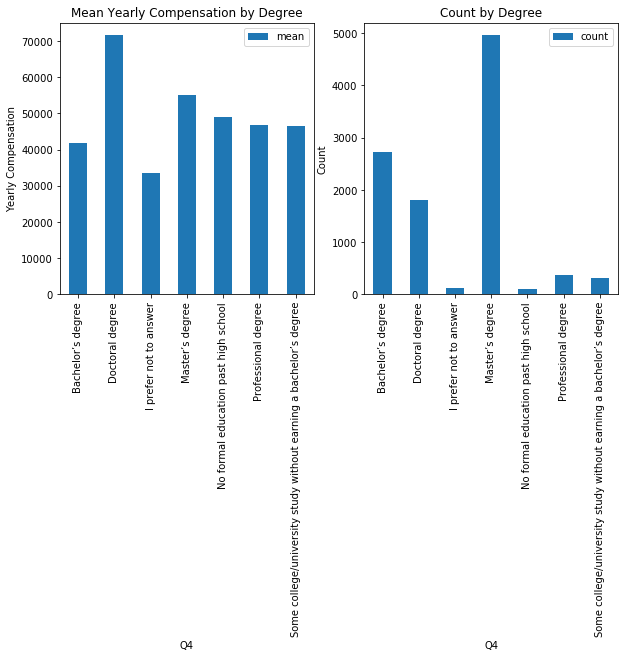

In [23]:
education_vs_salary = kaggle_new.groupby('Q4').Q10.agg(['count', 'mean'])
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = education_vs_salary.plot(y='mean',kind="bar",title="Mean Yearly Compensation by Degree",ax=axes[0],figsize=(10,5))
ax.set_ylabel("Yearly Compensation")
ax = education_vs_salary.plot(y='count',kind="bar",title="Count by Degree",ax=axes[1])
ax.set_ylabel("Count")
plt.show()

The graph below shows the average compensation based on job title and the count which illustrates how most of the job titles are within the 40-70K range and most respondents of the survey are Data Scientists. Therefore, based on this graph and the one above we can assume that the Data Scientists with Master's Degrees are represented more than any other in the sample population. Consequently, features which are important to Data Scientists, such as the ability to use Type Script, may be more correlated more strongly with salary in the logistic regression than other features which have weaker correlation. 

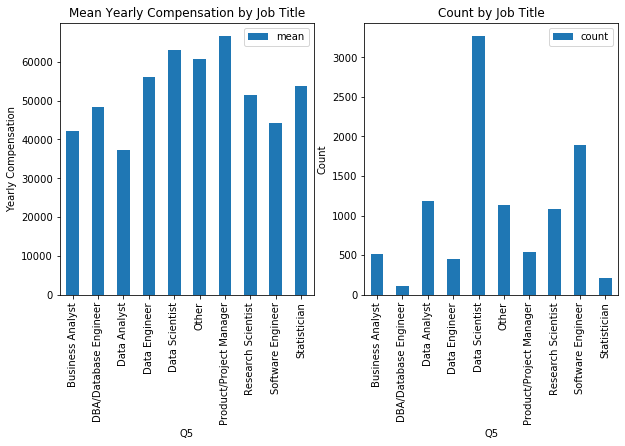

In [139]:
title_vs_salary = kaggle_new.groupby('Q5').Q10.agg(['count', 'mean'])
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = title_vs_salary.plot(y='mean',kind="bar",title="Mean Yearly Compensation by Job Title",ax=axes[0],figsize=(10,5))
ax.set_ylabel("Yearly Compensation")
ax = title_vs_salary.plot(y='count',kind="bar",title="Count by Job Title",ax=axes[1])
ax.set_ylabel("Count")
plt.show()

Based on the graphs below, it is evident that males on average earn approximately 10,000 USD more than females. In addition, the sample population has more than 4 times males compared to females. 

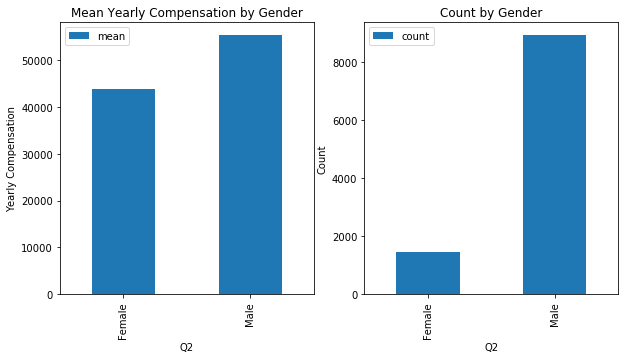

In [140]:
gender_dict = {0.0: 'Male', 1.0: "Female"}
education_vs_salary = kaggle_new.replace({'Q2': gender_dict}).groupby('Q2').Q10.agg(['count', 'mean'])
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = education_vs_salary.plot(y='mean',kind="bar",title="Mean Yearly Compensation by Gender",ax=axes[0],figsize=(10,5))
ax.set_ylabel("Yearly Compensation")

ax = education_vs_salary.plot(y='count',kind="bar",title="Count by Gender",ax=axes[1])
ax.set_ylabel("Count")
plt.show()

### Confidence Intervals

In [141]:
from scipy import stats
salary_vs_country = kaggle_new[['Q3','Q10']]
mu_US, sigma_US = np.mean(salary_vs_country[salary_vs_country['Q3']=='United States of America']['Q10']), np.std(salary_vs_country[salary_vs_country['Q3']=='United States of America']['Q10'])
print ("For respondents who are from the US: mean = %G, st. dev = %g" % (mu_US, sigma_US))

For respondents who are from the US: mean = 126868, st. dev = 81930.6


In [142]:
mu_India, sigma_India = np.mean(salary_vs_country[salary_vs_country['Q3']=='India']['Q10']), np.std(salary_vs_country[salary_vs_country['Q3']=='India']['Q10'])
print ("For respondents who are from India: mean = %G, st. dev = %g" % (mu_India, sigma_India))

For respondents who are from India: mean = 20926.4, st. dev = 42686.2


In [143]:
len_US = len(salary_vs_country[salary_vs_country['Q3']=='United States of America'])
len_US

1868

In [144]:
len_India = len(salary_vs_country[salary_vs_country['Q3']=='India'])
len_India

1903

In [145]:
conf_int_US_salary = stats.norm.interval( 0.95, loc = mu_US, scale = sigma_US/np.sqrt(len_US) )
print ("95%% confidence interval for Males salary class = [%g %g]" % (conf_int_US_salary[0], conf_int_US_salary[1]))

95% confidence interval for Males salary class = [123153 130584]


In [146]:
conf_int_India_salary = stats.norm.interval( 0.95, loc = mu_India, scale = sigma_India/np.sqrt(len_India) )
print ("95%% confidence interval for Females salary class = [%g %g]" % (conf_int_India_salary[0], conf_int_India_salary[1]))

95% confidence interval for Females salary class = [19008.6 22844.3]


In [147]:
US = salary_vs_country[salary_vs_country['Q3']=='United States of America']['Q10']
India = salary_vs_country[salary_vs_country['Q3']=='India']['Q10']

### Bootstrapping

In [148]:
US_salary_values = np.array(salary_vs_country[salary_vs_country['Q3']=='United States of America']['Q10'].values)
India_salary_values = np.array(salary_vs_country[salary_vs_country['Q3']=='India']['Q10'].values)

In [149]:
n = 1000
m = 10000
N_US = len(US_salary_values)
N_India = len(India_salary_values)
US_avg_salary = []
India_avg_salary = []
for i in range(m):
    US_avg_salary.append(np.mean(US_salary_values[np.random.randint(N_US, size=n)]))
    India_avg_salary.append(np.mean(India_salary_values[np.random.randint(N_India, size=n)]))

In [150]:
x_min = min(np.min(US_avg_salary),np.min(India_avg_salary))
x_max = max(np.max(US_avg_salary),np.max(India_avg_salary))

Based on the graph below, which shows the normal distribution of the salary data for India and the US, it is evident there is statistically significant difference in salary in India vs. the United States. This could influence the logistic regression where India is strongly negatively correlated with salary whereas the US is highly positively correlated. 

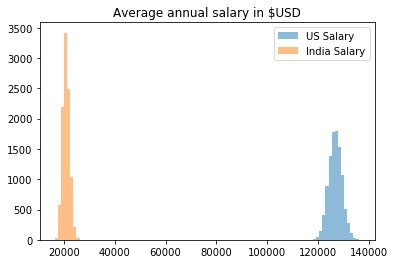

In [151]:
x_US = US_avg_salary
y_India = India_avg_salary

bins = np.linspace(x_min, x_max, 100)

plt.hist(x_US, bins, alpha=0.5, label="US Salary")
plt.hist(y_India, bins, alpha=0.5, label="India Salary")
plt.legend(loc='upper right')
plt.legend(loc='best')
plt.title('Average annual salary in \$USD')
plt.show()

In [152]:
new = kaggle_new[['Q10', 'Q2', 'Q4']].copy()
masters =  kaggle_new['Q4']=='Master’s degree'
new_masters = new[masters]
print(new_masters.head())

      Q10   Q2               Q4
1  275000  0.0  Master’s degree
3   65000  0.0  Master’s degree
4   12500  0.0  Master’s degree
6     500  0.0  Master’s degree
7    2500  0.0  Master’s degree


In [153]:
mu_male_mast, sigma_male_mast = np.mean(new_masters[new_masters['Q2']==0.0]['Q10']), np.std(new_masters[new_masters['Q2']==0.0]['Q10'])
print ("For respondents who are Male: mean = %G, st. dev = %g" % (mu_male_mast, sigma_male_mast))

For respondents who are Male: mean = 56796.8, st. dev = 66071.8


In [154]:
mu_female_mast, sigma_female_mast = np.mean(new_masters[new_masters['Q2']==1.0]['Q10']), np.std(new_masters[new_masters['Q2']==1.0]['Q10'])
print ("For respondents who are Female: mean = %G, st. dev = %g" % (mu_female_mast, sigma_female_mast))

For respondents who are Female: mean = 46021.7, st. dev = 53899.4


In [155]:
len_Male_mast = len(new_masters[new_masters['Q2']==0.0])
len_Male_mast

4222

In [156]:
len_Female_mast = len(new_masters[new_masters['Q2']==1.0])
len_Female_mast

736

In [157]:
conf_int_male_salary_mast = stats.norm.interval( 0.95, loc = mu_male_mast, scale = sigma_male_mast/np.sqrt(len_Male_mast) )
print ("95%% confidence interval for Males salary class = [%g %g]" % (conf_int_male_salary_mast[0], conf_int_male_salary_mast[1]))

95% confidence interval for Males salary class = [54803.8 58789.8]


In [158]:
conf_int_Female_salary_mast = stats.norm.interval( 0.95, loc = mu_female_mast, scale = sigma_female_mast/np.sqrt(len_Female_mast) )
print ("95%% confidence interval for Females salary class = [%g %g]" % (conf_int_Female_salary_mast[0], conf_int_Female_salary_mast[1]))

95% confidence interval for Females salary class = [42127.8 49915.7]


In [159]:
Males = new_masters[new_masters['Q2']==0.0]['Q10']
Females = new_masters[new_masters['Q2']==1.0]['Q10']

### Bootstrapping

In [161]:
male_salary_values_mast = np.array(new_masters[new_masters['Q2']==0.0]['Q10'].values)
female_salary_values_mast = np.array(new_masters[new_masters['Q2']==1.0]['Q10'].values)

In [162]:
n = 1000
m = 10000
N_males = len(male_salary_values_mast)
N_females = len(female_salary_values_mast)
male_avg_salary_mast = []
female_avg_salary_mast = []
for i in range(m):
    male_avg_salary_mast.append(np.mean(male_salary_values_mast[np.random.randint(N_males, size=n)]))
    female_avg_salary_mast.append(np.mean(female_salary_values_mast[np.random.randint(N_females, size=n)]))

In [163]:
x_min_mast = min(np.min(male_avg_salary_mast),np.min(female_avg_salary_mast))
x_max_mast = max(np.max(male_avg_salary_mast),np.max(female_avg_salary_mast))

Next, I wanted to compare if the salary gap remained between males and females when I keep education constant between the two samples to compare. For the graph below, only respondents who chose Master's degree were included in the normal distribution. The result shows that even when the education level is the same for both males and females there is still a significant wage gap between the two. 

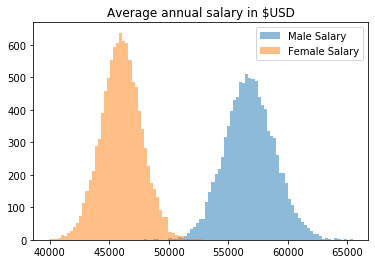

In [164]:
x_male_mast = male_avg_salary_mast
y_female_mast = female_avg_salary_mast

bins = np.linspace(x_min_mast, x_max_mast, 100)

plt.hist(x_male_mast, bins, alpha=0.5, label="Male Salary")
plt.hist(y_female_mast, bins, alpha=0.5, label="Female Salary")
plt.legend(loc='upper right')
plt.legend(loc='best')
plt.title('Average annual salary in \$USD')
plt.show()

Finally, for the last graph I chose to plot in 3D to obtain a better understanding of how two features interact to influence salary prediction. For the graph below, I compare age and number of years coding with salary. It is evident that the majority of the data points are concentrated at 0 years of coding and within the 20 - 40 age groups. The younger age demographic and lack of coding skills could be a reason for the lower salary level in that range. Respondents with 12.5+ years of coding and over the age of 40 tended to earn more in compensation. 

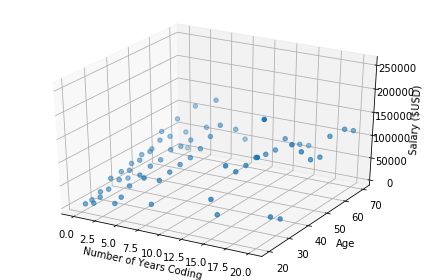

In [165]:
from mpl_toolkits.mplot3d import Axes3D
graph_3d_df = pd.DataFrame({'Q10':kaggle_new.groupby(['Q1','Q15'])['Q10'].mean()}).reset_index()
X_3d = graph_3d_df['Q1'].values
Y_3d = graph_3d_df['Q15'].values
Z_3d = graph_3d_df['Q10'].values
df_3d = pd.DataFrame({'x': X_3d, 'y': Y_3d, 'z': Z_3d}, index = range(len(X_3d)))
plot_3d = plt.figure().gca(projection='3d')
plot_3d.scatter(df_3d['y'],df_3d['x'],df_3d['z'])
plot_3d.set_xlabel('Number of Years Coding')
plot_3d.set_ylabel('Age')
plot_3d.set_zlabel('Salary ($USD)')
plt.rcParams['figure.figsize'] = (10, 10)
plt.tight_layout()
plt.show()

### **Feature Selection**

A feature is defined as the input and/or data which feeds into machine learning algorithms. Feature engineering is important because in order for a machine learning algorithm to work, the algorithm requires features which have specific characteristics. Subsequently, the features must be prepped through feature engineering to be compatible with the algorithm and to improve or enhance the performance of the algorithm.  

### Least Absolute Shrinkage and Selection Operator (LASSO)

**Describe the technique**
<br>
LASSO technique reduces the variance of my model through L1 regularization of penalizing the highest coefficients. There are larger penalties as the coefficients approach zero and consequently, LASSO will automatically eliminate unimportant coefficients. 
<br>
<br>
Justify Approach
<br>
I chose LASSO instead of Ridge because LASSO performs automatic variable selection by forcing coefficients to be equal to zero and alerts me of the variables that are important. Another advantage of LASSO is it helps avoid over-fitting my model by reducing variance. Also, LASSO ignores features with no coefficients which improves speed of the computation. 

#### Split the data into training and test datasets

Now, it is time to split the data into training and test data. For the training data I will take 70% of my data. 

In [166]:
y = kaggle_new2['Q10']
X = kaggle_new2.drop(['Q10'], axis=1, inplace = False)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

Next, I calculate the Real Mean Squared Error (RSME) which shows the squared mean error between the predicted and actual values. 

In [168]:
def rmse_cv(model): 
    rmse = np.sqrt(-cross_val_score(model,X_train, y_train, scoring='neg_mean_squared_error', cv=5))
    return rmse 

Next, I will use a LASSO to find the coefficients of importance. 

In [169]:
model_lasso = LassoCV(alphas = [1,0.1,0.001,0.0005]).fit(X_train,y_train)
rmse_cv(model_lasso).mean()
coef = pd.Series(model_lasso.coef_,index = X_train.columns)
print('Lasso picked ' + str(sum(coef!= 0)) + ' variables and eliminated the other ' + str(sum(coef ==0)) + " variables")

Lasso picked 149 variables and eliminated the other 8 variables


Variables of interest will have the highest absolute value for their coefficients. In the bar graph below I display the first ten coefficients of interest (i.e. have the highest positive magnitude) and the last ten coefficients (i.e. have the largest negative magnitude). 

**Which of the original attributes in the data are most related to a survey respondents yearly compensation**

Based on the Correlation Graph below it is evident that Q19_TypeScript has the strongest correlation with salary. This is a positive correlation and therefore, respondents who use TypeScript also bring home a higher salary. In the graph, I show the top 40 positively correlated coefficients and the top 40 negatively correlated coefficients. These coefficients will be used for the logistic regression and the other less important coefficients will be eliminated from the analysis. 

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

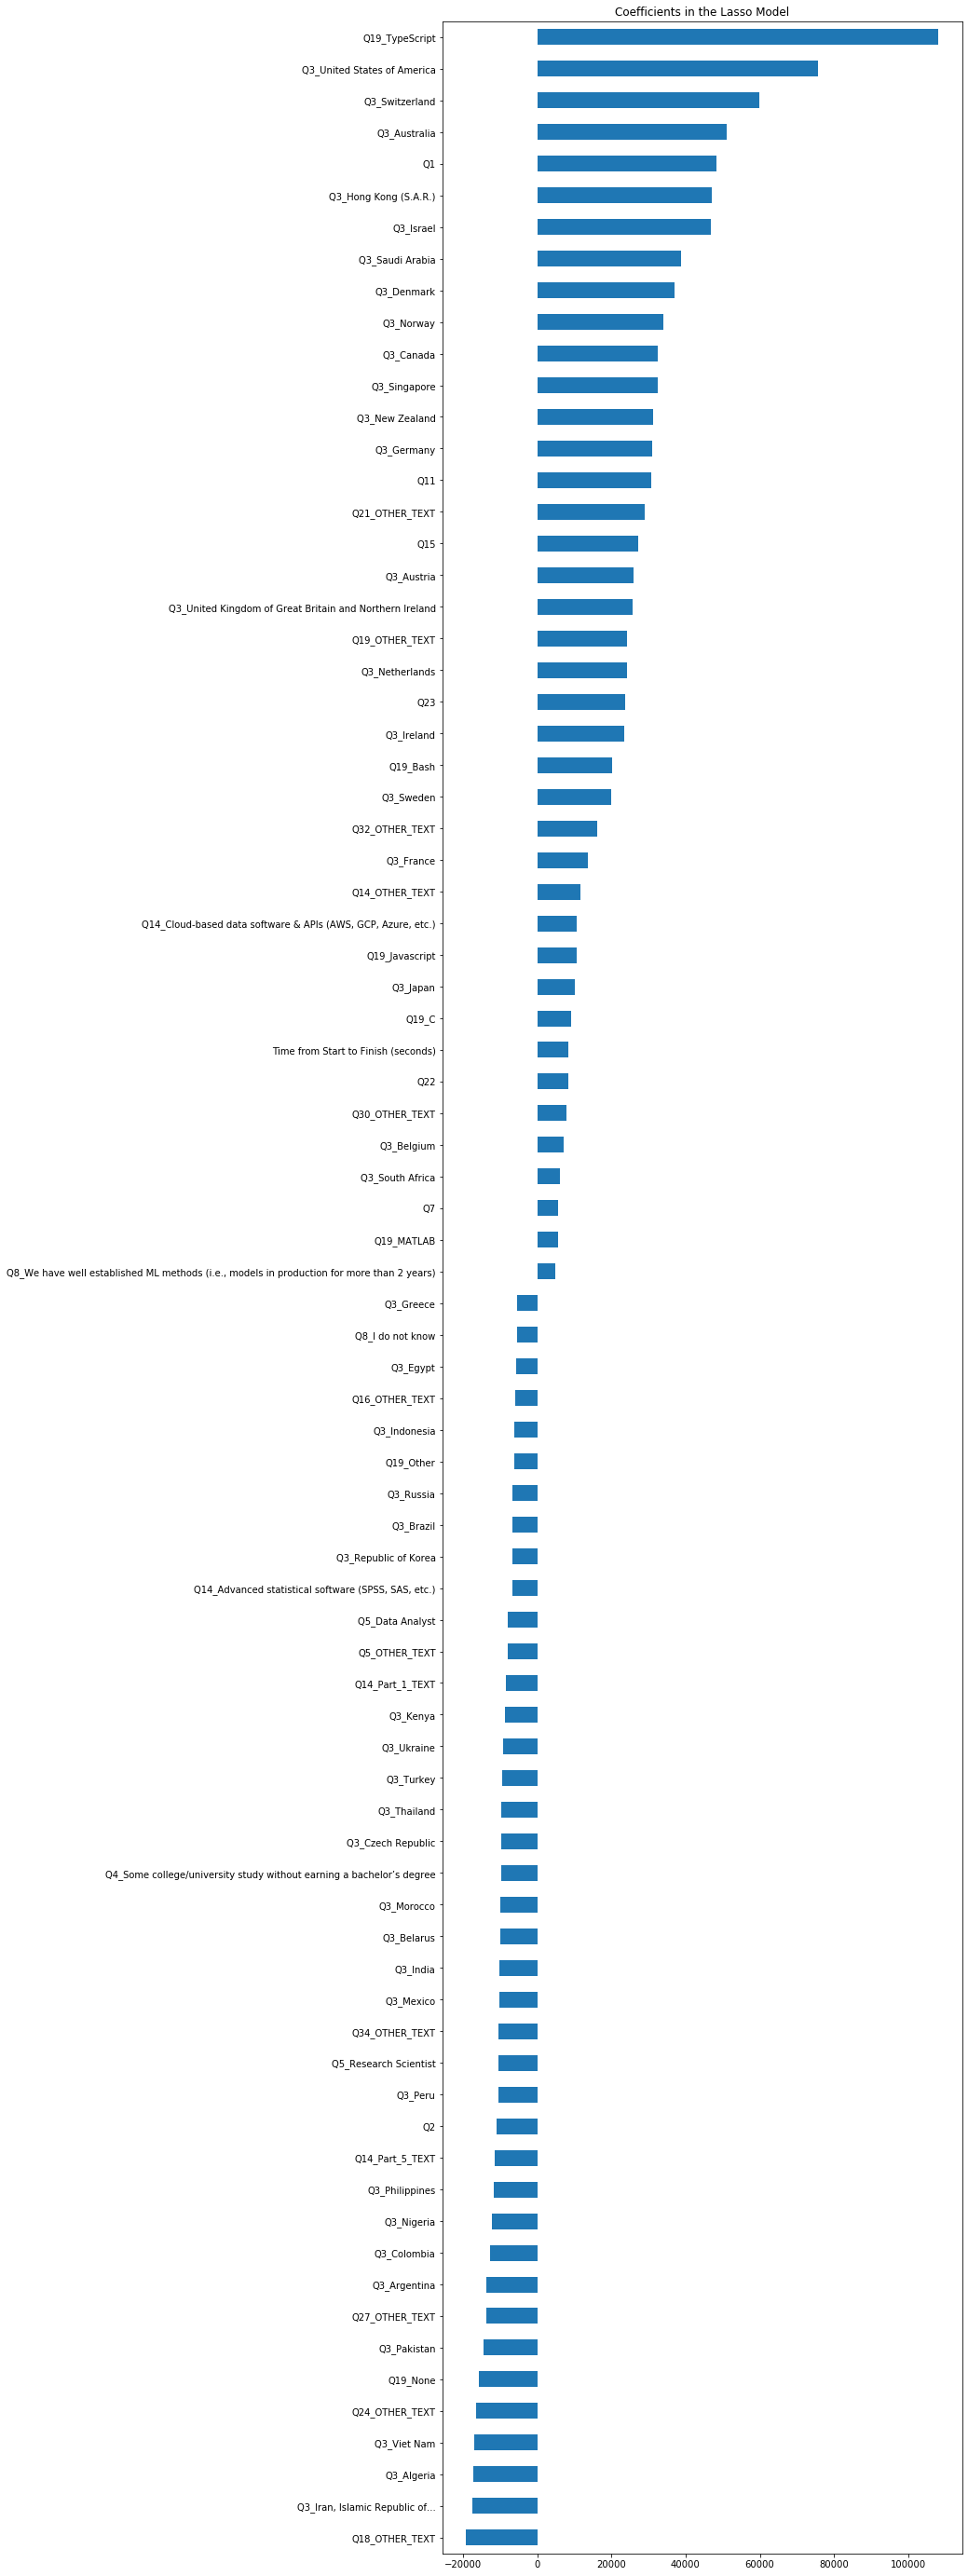

In [170]:
imp_coef = pd.concat([coef.sort_values().head(40), coef.sort_values().tail(40)])
plt.rcParams['figure.figsize'] = (10, 50)
imp_coef.plot(kind='barh')
plt.title('Coefficients in the Lasso Model')

The graph below illustrates the residual error plot for the training data with error values concentrating around 0. From the residuals graph it is evident that majority of data points are concentrated close to 0 which is the desired outcome for the LASSO.  

Text(0.5, 1.0, 'Residual Error Plot for Training Dataset')

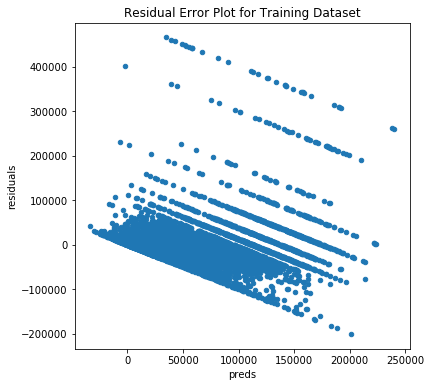

In [153]:
plt.rcParams['figure.figsize'] = (6.0,6.0)
preds = pd.DataFrame({'preds':model_lasso.predict(X_train), 'true':y_train})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals', kind = 'scatter')
plt.title("Residual Error Plot for Training Dataset")

The graph below illustrates the residual error plot for the testing data with error values concentrating around 0.

Text(0.5, 1.0, 'Residual Error Plot for Testing Dataset')

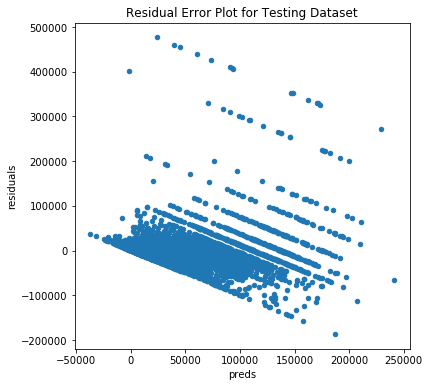

In [154]:
plt.rcParams['figure.figsize'] = (6.0,6.0)
preds = pd.DataFrame({'preds':model_lasso.predict(X_test), 'true':y_test})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals', kind = 'scatter')
plt.title("Residual Error Plot for Testing Dataset")

In [171]:
X = kaggle_new2[imp_coef.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

### Logistic Regression

In classification the algorithms produce discrete values, unlike linear regression where the output can be continuous. Logistic regression uses the sigmoid function where the output is the estimated probability that y=1. When you insert a feature vector into the sigmoid function, i.e. the hypothesis function, the output is the probability of that feature vector. This is what will be the output of the following logistic regression. In addition, in order to find the parameters/coefficients which will minimize the cost function I will need to do a gradient descent using the cost function for logistic regression in order to achieve convexity which can be used in a gradient descent. There are multiple algorithms for a gradient descent and the optimal algorithm and regularization factor will be tested. 

In [1]:
model = LogisticRegression()    
model.fit(X_train, y_train)

NameError: name 'LogisticRegression' is not defined

In [29]:
predictions = model.predict(X_test)
    
TN = confusion_matrix(y_test, predictions)[0][0]
FP = confusion_matrix(y_test, predictions)[0][1]
FN = confusion_matrix(y_test, predictions)[1][0]
TP = confusion_matrix(y_test, predictions)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total=9

print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))   

This model got an accuracy of 71.47% on the testing set


**How does your model accuracy compare across folds?**
<br>
The most accurate Fold is the 1st fold at 80.7% accuracy and at the lowest is 69.1%. 
<br>
<br>
**What is the average and variance of accuracy for folds?**
<br>
The average accuracy over the 10-folds was 75.027% with a variance of 4.027%. 

In [38]:
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    TN = confusion_matrix(y_test, predictions)[0][0]
    FP = confusion_matrix(y_test, predictions)[0][1]
    FN = confusion_matrix(y_test, predictions)[1][0]
    TP = confusion_matrix(y_test, predictions)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))
    
print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 0.795%
Fold 2: Accuracy: 0.759%
Fold 3: Accuracy: 0.682%
Fold 4: Accuracy: 0.708%
Fold 5: Accuracy: 0.762%
Fold 6: Accuracy: 0.759%
Fold 7: Accuracy: 0.807%
Fold 8: Accuracy: 0.691%
Fold 9: Accuracy: 0.763%
Fold 10: Accuracy: 0.776%
Average Score: 75.027%(4.027%)


**Treating each value of hyperparameters as a new model, which model performed best? Base from bias-variance tradeoff**

##### Hyperparameter Tuning Results
C= 100
<br>
Solver = 'newton-cg'
<br>

##### Model Tuning Explained
In the following code, I will use C and solver to find the optimal hyperparameters for my model. The C value is the inverse of the strength of regularization. Regularization prevents over-fitting by applying a penalty to increase the magnitude of the coefficients. Based on the results above, a high C value assumes there is lower strength for regularization which means the model has a lower penalty for over-fitting. Consequently, based on this data, it is assumed the model is under-fitting and there is a high bias and low variance problem.  

In [30]:
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:

    for solver in ['newton-cg','lbfgs','liblinear','sag']:
    
        
        model = LogisticRegression(C=C, solver=solver)
        accuracy = np.zeros(10)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            TN = confusion_matrix(y_test, predictions)[0][0]
            FP = confusion_matrix(y_test, predictions)[0][1]
            FN = confusion_matrix(y_test, predictions)[1][0]
            TP = confusion_matrix(y_test, predictions)[1][1]
            total = TN + FP + FN + TP
            ACC = (TP + TN) / float(total)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 100, 'solver': 'newton-cg'}
Best Score: 74.063%(3.542%)

The optimal log model uses C=100, and a newton-cg solver, and has a cross validation score of 74.063% with a standard deviation of 3.542%


Moreover, in the code below, I develop a graph which shows C value in relation to accuracy. From the graph, it is evident that for C values between 1 and 111 the accuracy is the highest around 40 and then decreases before going back up at around 100. However, this graph only represents data using the default algorithm which is why the results are different from the model tuning above.

In [44]:
folds = 2 
i = 0
columns = ['C Value', "Accuracy"]
results = pd.DataFrame(columns = columns)

for C_ in range (1, 121, 10):
    
    scaler = StandardScaler()
    kfold = KFold(n_splits=folds)
    kfold.get_n_splits(X)
    model = LogisticRegression (C=C_)
    print ('C = :' + str(C_))
    accuracy = np.zeros(folds)
    np_idx = 0
    
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        TN = confusion_matrix(y_test, predictions)[0][0]
        FP = confusion_matrix(y_test, predictions)[0][1]
        FN = confusion_matrix(y_test, predictions)[1][0]
        TP = confusion_matrix(y_test, predictions)[1][1]
        total = TN + FP + FN + TP
        ACC = (TP + TN) / float(total)

        accuracy[np_idx] = ACC*100
        np_idx += 1

        print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))
    
    accuracy_= round(np.mean(accuracy),3)
    print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

    results.loc[i] = [str(C_), str(accuracy_)]
    i += 1

C = :1
Fold 1: Accuracy: 0.727%
Fold 2: Accuracy: 0.737%
Average Score: 73.227%(0.5%)
C = :11
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.74%
Average Score: 73.676%(0.299%)
C = :21
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.74%
Average Score: 73.676%(0.299%)
C = :31
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.74%
Average Score: 73.676%(0.299%)
C = :41
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.74%
Average Score: 73.676%(0.299%)
C = :51
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.74%
Average Score: 73.676%(0.299%)
C = :61
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.739%
Average Score: 73.649%(0.273%)
C = :71
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.739%
Average Score: 73.649%(0.273%)
C = :81
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.739%
Average Score: 73.649%(0.273%)
C = :91
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.739%
Average Score: 73.649%(0.273%)
C = :101
Fold 1: Accuracy: 0.734%
Fold 2: Accuracy: 0.739%
Average Score: 73.649%(0.273%)
C = :111
Fold 1: Accuracy: 0

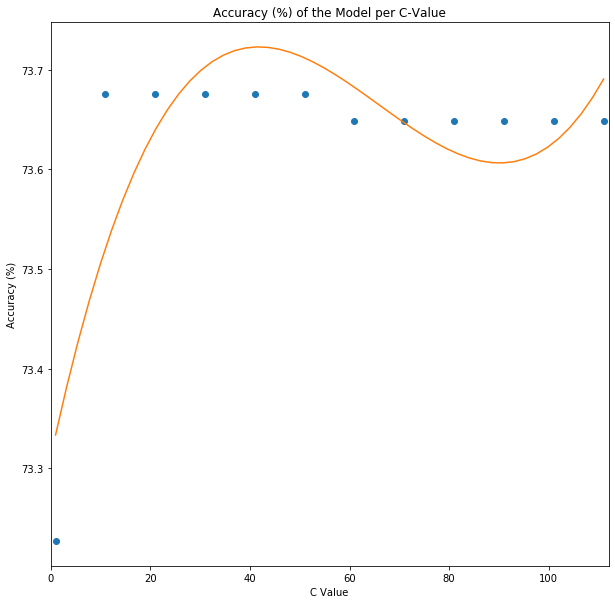

In [48]:
x_graph = results['C Value'].astype(float)
y_graph = results["Accuracy"].astype(float)

z = np.polyfit(x_graph, y_graph, 3)
f = np.poly1d(z)

x_new = np.linspace(x_graph[0], x_graph[11], 50)
y_new = f(x_new)
plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(x_graph,y_graph,'o', x_new, y_new)
plt.xlim([x_graph[0]-1, x_graph[11] + 1 ])
plt.title('Accuracy (%) of the Model per C-Value')
plt.xlabel('C Value')
plt.ylabel('Accuracy (%)')
plt.show()

#### Probability Distribution 

Now, I will develop the probability distribution by first implementing the optimal solver and C value into my logistic regression. Then I use the predict_proba() function to predict the probability for the regression. Lastly, I will use a for loop to organize my data into a pandas dataframe with only two columns Salary Class and Probability. 

In [176]:
clf = LogisticRegression(random_state=0, solver = 'newton-cg', C = 100).fit(X, y)
result = clf.predict_proba(X)
result

array([[6.50326729e-03, 1.75837625e-02, 1.81900971e-02, ...,
        1.60188438e-02, 4.08970508e-02, 2.84716193e-02],
       [2.80731437e-02, 2.32144452e-04, 1.77674856e-04, ...,
        5.82518592e-03, 2.48634046e-03, 3.05795674e-02],
       [2.17853504e-01, 5.73371304e-02, 4.10830413e-02, ...,
        2.40208936e-04, 3.72151965e-04, 3.63149085e-04],
       ...,
       [9.64164655e-02, 6.30019971e-02, 4.14545674e-02, ...,
        2.13132078e-04, 1.05168651e-04, 7.03946093e-04],
       [3.33192088e-02, 2.62440512e-04, 2.38164736e-04, ...,
        2.21626431e-03, 1.36267003e-03, 4.28788759e-03],
       [5.88304427e-03, 1.41434208e-02, 1.83808891e-02, ...,
        2.45100341e-04, 5.40002239e-03, 1.12720709e-05]])

In [67]:
column_names = ["Salary_Class (USD $)", "Probability (%)"]
Probability_distribution_df = pd.DataFrame(columns = column_names)
i = 0
for salary_class in clf.classes_: 
    Probability_distribution_df.loc[i] = [str(salary_class), round(100*(result[:,i].mean()), 2)]
    i += 1

In [68]:
Probability_distribution_df

,Salary_Class (USD $),Probability (%)
0,500,10.21
1,1500,4.07
2,2500,2.90
3,3500,2.32
4,4500,2.25
5,6250,4.10
6,8750,3.07
7,12500,6.68
8,17500,4.42
9,22500,4.35


Text(0, 0.5, 'Probability (%)')

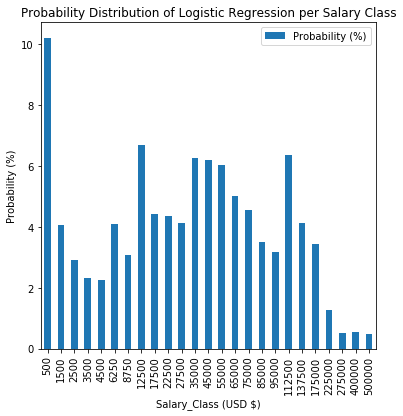

In [70]:
Probability_distribution_df.plot(kind='bar',x='Salary Class (USD $)',y='Probability (%)')
plt.title('Probability Distribution of Logistic Regression per Salary Class')
plt.xlabel('Salary_Class (USD $)')
plt.ylabel('Probability (%)')

The graph above shows the output of my algorithm which is the probability an individual would fall in one of the salary brackets based on the features represented in the logistic regression. Based on this graph, there may be some bias in the sample from students who could have a high level of education and earn a low salary since they are still in school which accounts for such a high probability in the 500 salary range. Apart from the 500 salary bracket, the other salaries fall into shape which resembles a normal distribution with the majority of the probability concentrating in the middle of the graph and the outer sections having a lower probability. 

# **Discussion**

### **Testing**

##### **Model Tuning**

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

#### Learning Curve

<module 'matplotlib.pyplot' from '/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/matplotlib/pyplot.py'>

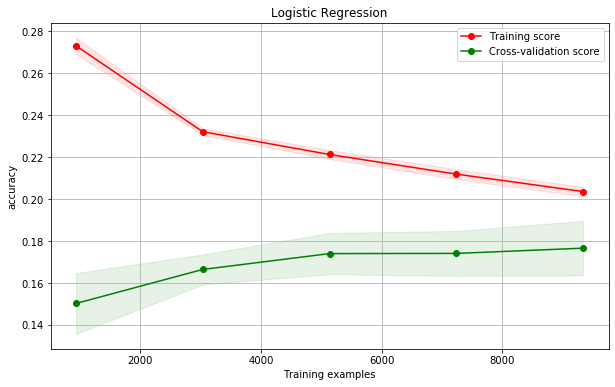

In [133]:
plot_learning_curve(model,'Logistic Regression', X, y, cv=10)

#### Bias vs Variance 

**How does your model perform on the test set vs. training set? How to increase accuracy (test, training)? Is it overfitting or underfitting? Why?**

Based on the Learning Curve above, when the size of the training data is small the variance between the training set and validation set is large, with higher accuracy for the training set and lower for the validation set. This is possibly because with only a small amount of training examples the model cannot generalize very accurately. However, as the number of training examples increase, the validation set and training set converge. This is because the model gets better at generalizing as more data is fed into the model and consequently, bias decreases. 

Based on the graph, the error of the training set is much lower than the error in the validation set. Consequently, the variance must be high for the model due to the model over-fitting the training data. Moreover, based on these observations I deduce the major problem arises from variance and I will classify this model as high variance and low bias with an over-fitting problem.   

Improvements
<br> 
Based on the information extracted from the graph, at the maximum training size, the validation curve is not plateauing which means that by adding more training instances I can converge the sets further and increase the performance of my model.  

# **References**

Hancock, B., & Schaninger, B. (2019). *The new science of talent: From roles to returns.* Mckinsey & Company. https://www.mckinsey.com/business-functions/organization/our-insights/the-new-science-of-talent-from-roles-to-returns

Rai, S.S. (2019, February, 28). *Three Methods to Handle Missing Data.* Oracle Data Science Blog. https://blogs.oracle.com/datascience/3-methods-to-handle-missing-data

Van der Aalst W. (2016). Data Science in Action. In: Process Mining. Springer, Berlin, Heidelberg